In [2]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet as wn

import re

from time import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
file_path = 'data/TweetsPolaridadSEPLN.csv'
original_tweets_df = pd.read_csv(file_path, index_col=None, header=0, sep='\t')
print(original_tweets_df.describe())
print(original_tweets_df.head())

                      tweetid          user               content  \
count                   60798         60798                 60798   
unique                  60798           158                 60405   
top      165728612941692928,0  mariviromero  Buenos días a todos!   
freq                        1          7138                   111   

                       date   lang polarity  topic  
count                 60798  60798    60798  60798  
unique                60510      1        6     10  
top     2011-12-11T12:56:51     es     NONE  otros  
freq                      4  60798    21416  28189  
                 tweetid            user  \
0   142378325086715904,0     jesusmarana   
1   142379080808013824,0       EvaORegan   
2   142379173120442368,0  LosadaPescador   
3   142379815708803072,0    mgilguerrero   
4   142381190123499520,0  pedroj_ramirez   

                                             content                 date  \
0  Portada 'Público', viernes. Fabra al banquil

In [4]:
strong_negative_tweets = original_tweets_df[original_tweets_df.polarity == 'N+'][['content','polarity']]
standar_negative_tweets = original_tweets_df[original_tweets_df.polarity == 'N'][['content','polarity']]

strong_positive_tweets = original_tweets_df[original_tweets_df.polarity == 'P+'][['content','polarity']]
standar_positive_tweets = original_tweets_df[original_tweets_df.polarity == 'P'][['content','polarity']]

negative_tweets = pd.concat([strong_negative_tweets,standar_negative_tweets], ignore_index=True)
positive_tweets = pd.concat([strong_positive_tweets,standar_positive_tweets], ignore_index=True)

negative_tweets.polarity = "negative"
positive_tweets.polarity = "positive"

total_tweets = pd.concat([negative_tweets,positive_tweets], ignore_index=True)
print(total_tweets.describe())
print(total_tweets.head())

                                                  content  polarity
count                                               38077     38077
unique                                              37926         2
top     ¡Noticias descombacantes! está disponible! htt...  positive
freq                                                   63     22233
                                             content  polarity
0  Dado q la deuda privada es superior a la publi...  negative
1  TEPCO inyecta nitrógeno en los reactores de Fu...  negative
2  “@Declaracion: «Cualquier injusticia contra un...  negative
3  ¡Qué estrés!, la presidenta de la diputación d...  negative
4  Hoy entrego mi credencial en el Congreso. Una ...  negative


In [5]:
total_data_content = total_tweets.content
total_data_target = total_tweets.polarity

In [6]:
X_train, X_test, y_train, y_test = train_test_split(total_data_content, 
                                                    total_data_target, 
                                                    test_size=0.3, 
                                                    random_state=40)

In [7]:
print("Positivos entrenamiento:", len(y_train[y_train == 'positive']))
print("Negativos entrenamiento:", len(y_train[y_train == 'negative']))
print("Positivos pruebas:", len(y_test[y_test == 'positive']))
print("Negativos pruebas:", len(y_test[y_test == 'negative']))

Positivos entrenamiento: 15547
Negativos entrenamiento: 11106
Positivos pruebas: 6686
Negativos pruebas: 4738


# Metodos para correr los respectivos experimentos

## Metodo usado para probar y evaluar un clasificador
El siguiente metodo sirve para evaluar un clasificador enviado como parametro, junto con los datos con que debe ser probado. Las metricas usadas para medir la efectividad del clasificador son la exactitud (accuracy), la precision, la exhaustividad (recall) y el valor-f1 (f1-score). El metodo retorna la matriz de confunsion de los resultados obtenidos.

In [7]:
def test_predictions_and_return_cm(clf, test_data, true_data):
    predicted = clf.predict(test_data)
    
    accuracy = metrics.accuracy_score(true_data, predicted)
    precision, recall, f1_score, support = metrics.precision_recall_fscore_support(true_data, predicted, 
                                                                                   average="macro")
    print("Exactitud:", accuracy)
    print("F1_score:", f1_score)
    print("Precision:", precision)
    print("Recall:", recall)
    print()
    print(metrics.classification_report(true_data, predicted, digits=4))
    cm = metrics.confusion_matrix(true_data, predicted)
    print(cm)
    print()
    return cm

## Metodo para imprimir la matriz de confusion
El siguiente metodo imprime la matriz de confusion y fue tomado de la documentacion scikit learn. En esta URL se puede encontrar la explicacion y codigo fuente
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
El siguiente metodo "test_nl_classifier" corre el metodo que evalúa el clasificador e imprime la matriz de confusion, es decir, corre los metodos usados para evaluar el clasificador y visualizar los resultados.

In [131]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')

In [132]:
def test_nl_classifier(clf, X_t, y_t):
    cm = test_predictions_and_return_cm(clf, X_t, y_t)
    plot_confusion_matrix(cm, classes=['negativos', 'positivos'])

## Metodo para entrenar un clasificador con GridSearchCV
Este metodo sirve para entrenar un clasificador buscando la mejor combinacion de parametros según el tipo de clasificador. Estos parametros se envían como un objeto diccionario en los argumentos del metodo y se nombran según sea el tipo de clasificador que también se envía en los argumentos del metodo. El metodo siguiente "print_clf_best_params" se usa para mostrar los mejores valores de los parametros obtenidos.

In [10]:
def train_nl_classifier(grid_parameters, clf_type, X, y):
    clf = GridSearchCV(clf_type, grid_parameters, n_jobs=-1, cv=10)
    t0 = time()
    clf.fit(X, y)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    print()
    return clf

In [11]:
def print_clf_best_params(grid_parameters, clf):
    print("Mejor resultado y parametro encontrados:")
    print("Mejor resultado (accuracy cv): ", clf.best_score_)
    for param_name in sorted(grid_parameters.keys()):
        print("%s: %r" % (param_name, clf.best_params_[param_name]))
    print()

## Metodos para vectorizar los textos de entranamiento y prueba
El metodo fit_train_test_vectors vectoriza los textos de entrenamiento y pruebas y los retorna como vectores de acuerdo al parametro vectorizer. Este metodo es muy importante porque según el parametro vectorizer se representan los textos con algun metodo de ponderacion (tf-idf, tf y binario) y se realizan los procesos de limpiezas indicados al crear el objeto vectorizador. El siguiente metodo es opcional llamarlo y sirve para imprimir las longitudes y formas de los conjuntos resultantes.

In [12]:
def fit_train_test_vectors(vectorizer, X_train, X_test):
    X_train_vector = vectorizer.fit_transform(X_train)
    X_test_vector = vectorizer.transform(X_test)
    return X_train_vector, X_test_vector

In [13]:
def print_train_test_shapes(vectorizer, X_train_vector, X_test_vector):
    print(X_train_vector.shape)
    print()
    
    print(X_test_vector.shape)
    print(vectorizer.get_feature_names()[-150:-100])

## Metodos usados para correr las pruebas de linea base y de cada etapa
Estos son los metodos mas importantes ya que usan todos los metodos explicados anteriormente y sirven para correr los experimentos de forma más rapida y replicable. El primer metodo se debe usar para crear la linea base, es decir, para encontrar los parametros ideales de los clasificadores usados con la linea base (sin ningun proceso de limpieza). El clasificador con mejor resultados puede ser recuperado de la lista de resultados que genera. Al tener el clasificador optimo para la linea base, se procedera a usar los parametros encontrados para hacer los experimentos con cada proceso de limpieza y evaluar que tanto afecta cada proceso por separado. Recibe los parametros vectorizer, grid_parameters y clf_type para ser usados en los metodos "train_nl_classifier" y "fit_train_test_vectors" explicados anteriormente (ver explicacion para entender que son los parametros).

In [14]:
def run_tests_splits(vectorizer, grid_parameters, clf_type):
    results = []
    random_states = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for state in random_states:
        print("random state: ", state)
        X_train, X_test, y_train, y_test = train_test_split(total_data_content, 
                                                            total_data_target, 
                                                            test_size=0.3, 
                                                            random_state=state)
        X_train_vector, X_test_vector = fit_train_test_vectors(vectorizer, X_train, X_test)
        clf = train_nl_classifier(grid_parameters, clf_type, X_train_vector, y_train)
        y_pred = clf.predict(X_test_vector)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1_score = metrics.f1_score(y_test, y_pred, average="macro")
        results.append((clf.best_score_, accuracy, f1_score, X_test_vector, y_test, clf, state, X_train_vector))
    return results

### Metodo para correr un experimento
De acuerdo a los resultados obtenidos por el metodo anterior, con este metodo se deben correr los experimentos respectivos a cada proceso de limpieza y con los parametros optimos encontrados en la linea base. Esto permite que los resultado obtenidos den una idea de que tanto afecto el proceso de limpieza sin que los parametros del clasificador sean una razon de sesgo o que le quiten validez a los resultados. Recibe los parametros vectorizer, grid_parameters y clf_type para ser usados en los metodos "train_nl_classifier" y "fit_train_test_vectors" explicados anteriormente (ver explicacion para entender que son los parametros).

In [71]:
def run_one_experiment(vectorizer, grid_parameters, clf_type, state):
    X_train, X_test, y_train, y_test = train_test_split(total_data_content, 
                                                        total_data_target, 
                                                        test_size=0.3, 
                                                        random_state=state)
    X_train_vector, X_test_vector = fit_train_test_vectors(vectorizer, X_train, X_test)
    print("Numero de caracteristicas: ", X_train_vector.shape)
    print()
    clf = train_nl_classifier(grid_parameters, clf_type, X_train_vector, y_train)
    y_pred = clf.predict(X_test_vector)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision, recall, f1_score, support = metrics.precision_recall_fscore_support(y_test, y_pred, 
                                                                                   average="macro")
    cm = metrics.confusion_matrix(y_test, y_pred)
    true_negatives = cm[0][0]
    true_positives = cm[1][1]
    false_positives = cm[0][1]
    false_negatives = cm[1][0]
    
    features_number = (X_train_vector.shape)[1]
    
    print_clf_best_params(grid_parameters, clf)
    test_nl_classifier(clf, X_test_vector, y_test)
    return (features_number, accuracy,f1_score,precision,recall,true_positives,true_negatives,false_positives,false_negatives)

In [16]:
def print_baseline_results(baseline_results, grid_parameters):
    selected_clf_info = max(baseline_results)
    print("Numero de caracteristicas: ", selected_clf_info[7].shape)
    print()
    print("Best score selected: ", selected_clf_info[0])
    print("Best Accuracy: ", selected_clf_info[1])
    print("Best F1-score: ", selected_clf_info[2])
    print("Best random state: ", selected_clf_info[6])
    selected_clf = selected_clf_info[5]
    print_clf_best_params(grid_parameters, selected_clf)
    print()
    X_t = selected_clf_info[3]
    y_t = selected_clf_info[4]
    test_nl_classifier(selected_clf, X_t, y_t)
    # for result in tf_baseline_results:
    #     print("Random State: ", result[6])
    #     print("Accuracy: ", result[0])
    #     print("F1-score: ", result[1])
    #     print("Best score: ", result[2])
    #     result_clf = result[5]
    #     print_clf_best_params(parameters_count, result_clf)
    #     print()

# Lineas base para cada representacion (tf-idf, tf, binaria)

In [17]:
def default_tokenize(text):
    regexp_tokenizer = RegexpTokenizer(u'(?u)\\b\\w\\w+\\b')
    tokens =  regexp_tokenizer.tokenize(text)
    return tokens

In [18]:
tf_vect_baseline = CountVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True)

tf_idf_vect_baseline = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True)

binary_vect_baseline = CountVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True,
                binary=True)

# Experimentos con el clasificador bayesiano
Los siguientes son los experimentos realizados para el clasificador bayesiano

In [19]:
parameters_nb = {'alpha': [4, 3, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

## Linea base y parametros optimos NB

### TF BaseLine

In [20]:
%%time
tf_baseline_results = run_tests_splits(tf_vect_baseline, parameters_nb, MultinomialNB())

random state:  10
train time: 2.813s

random state:  20
train time: 2.521s

random state:  30
train time: 2.698s

random state:  40
train time: 2.361s

random state:  50
train time: 2.638s

random state:  60
train time: 2.442s

random state:  70
train time: 2.667s

random state:  80
train time: 2.615s

random state:  90
train time: 2.398s

random state:  100
train time: 2.448s

CPU times: user 28.9 s, sys: 4.98 s, total: 33.9 s
Wall time: 37.6 s


Numero de caracteristicas:  (26653, 48349)

Best score selected:  0.8784001800922973
Best Accuracy:  0.8734243697478992
Best F1-score:  0.8701872862138964
Best random state:  40
Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8784001800922973
alpha: 3


Exactitud: 0.8734243697478992
F1_score: 0.8701872862138964
Precision: 0.8688230249792379
Recall: 0.8718475391394505

             precision    recall  f1-score   support

   negative     0.8372    0.8626    0.8497      4738
   positive     0.9005    0.8811    0.8907      6686

avg / total     0.8742    0.8734    0.8737     11424

[[4087  651]
 [ 795 5891]]

Confusion matrix, without normalization
[[4087  651]
 [ 795 5891]]


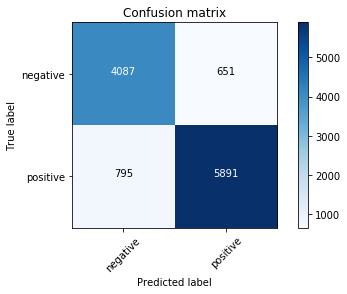

In [21]:
print_baseline_results(tf_baseline_results, parameters_nb)

### TF-IDF BaseLine

In [22]:
%%time
tf_idf_baseline_results = run_tests_splits(tf_idf_vect_baseline, parameters_nb, MultinomialNB())

random state:  10
train time: 2.752s

random state:  20
train time: 2.608s

random state:  30
train time: 2.648s

random state:  40
train time: 2.690s

random state:  50
train time: 2.789s

random state:  60
train time: 2.573s

random state:  70
train time: 2.752s

random state:  80
train time: 2.558s

random state:  90
train time: 2.627s

random state:  100
train time: 2.665s

CPU times: user 29.4 s, sys: 5.92 s, total: 35.4 s
Wall time: 39.1 s


Numero de caracteristicas:  (26653, 48372)

Best score selected:  0.8719093535436911
Best Accuracy:  0.8647584033613446
Best F1-score:  0.8584099477109906
Best random state:  30
Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8719093535436911
alpha: 1


Exactitud: 0.8647584033613446
F1_score: 0.8584099477109906
Precision: 0.8677352071046704
Recall: 0.8531272734459184

             precision    recall  f1-score   support

   negative     0.8793    0.7831    0.8284      4763
   positive     0.8562    0.9231    0.8884      6661

avg / total     0.8658    0.8648    0.8634     11424

[[3730 1033]
 [ 512 6149]]

Confusion matrix, without normalization
[[3730 1033]
 [ 512 6149]]


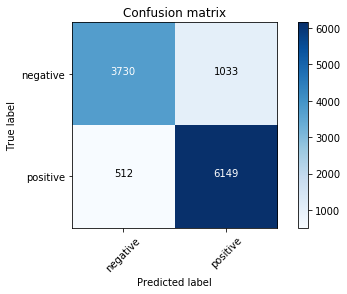

In [23]:
print_baseline_results(tf_idf_baseline_results, parameters_nb)

### Binary BaseLine

In [24]:
%%time
binary_baseline_results = run_tests_splits(binary_vect_baseline, parameters_nb, MultinomialNB())

random state:  10
train time: 2.617s

random state:  20
train time: 2.687s

random state:  30
train time: 2.685s

random state:  40
train time: 2.587s

random state:  50
train time: 2.826s

random state:  60
train time: 2.639s

random state:  70
train time: 2.729s

random state:  80
train time: 2.566s

random state:  90
train time: 3.001s

random state:  100
train time: 2.881s

CPU times: user 28.5 s, sys: 7.26 s, total: 35.7 s
Wall time: 39.2 s


Numero de caracteristicas:  (26653, 48349)

Best score selected:  0.8786252954639253
Best Accuracy:  0.8739495798319328
Best F1-score:  0.8703247515782714
Best random state:  40
Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8786252954639253
alpha: 3


Exactitud: 0.8739495798319328
F1_score: 0.8703247515782714
Precision: 0.8699113800047167
Recall: 0.8707589063897054

             precision    recall  f1-score   support

   negative     0.8453    0.8520    0.8486      4738
   positive     0.8946    0.8895    0.8920      6686

avg / total     0.8741    0.8739    0.8740     11424

[[4037  701]
 [ 739 5947]]

Confusion matrix, without normalization
[[4037  701]
 [ 739 5947]]


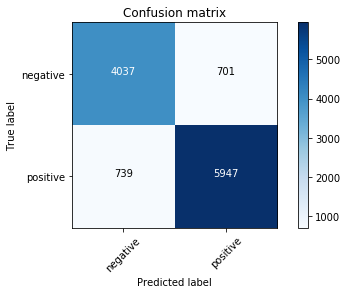

In [363]:
print_baseline_results(binary_baseline_results, parameters_nb)

In [134]:
all_experiments_results = []

## Prueba de la linea base con los parametros optimos
Esta prueba se hace para validar los resultados obtenidos anteriormente. Si esta bien debe dar lo mismo o un resultado muy similar dependiendo del clasificador. Por ejemplo con el clasificador bayesiano debe dar el mismo resultado.

Numero de caracteristicas:  (26653, 48349)

train time: 2.549s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8784001800922973
alpha: 3

Exactitud: 0.8734243697478992
F1_score: 0.8701872862138964
Precision: 0.8688230249792379
Recall: 0.8718475391394505

             precision    recall  f1-score   support

   negative     0.8372    0.8626    0.8497      4738
   positive     0.9005    0.8811    0.8907      6686

avg / total     0.8742    0.8734    0.8737     11424

[[4087  651]
 [ 795 5891]]

Confusion matrix, without normalization
[[4087  651]
 [ 795 5891]]


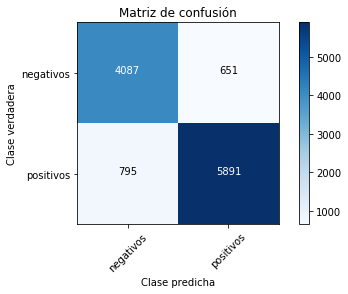

In [135]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_baseline = run_one_experiment(tf_vect_baseline, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_baseline)

Numero de caracteristicas:  (26653, 48372)

train time: 2.187s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8719093535436911
alpha: 1

Exactitud: 0.8647584033613446
F1_score: 0.8584099477109906
Precision: 0.8677352071046704
Recall: 0.8531272734459184

             precision    recall  f1-score   support

   negative     0.8793    0.7831    0.8284      4763
   positive     0.8562    0.9231    0.8884      6661

avg / total     0.8658    0.8648    0.8634     11424

[[3730 1033]
 [ 512 6149]]

Confusion matrix, without normalization
[[3730 1033]
 [ 512 6149]]


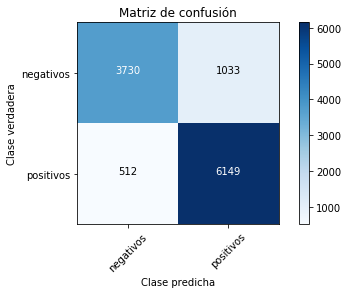

In [136]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_baseline = run_one_experiment(tf_idf_vect_baseline, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_baseline)

Numero de caracteristicas:  (26653, 48349)

train time: 2.246s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8786252954639253
alpha: 3

Exactitud: 0.8739495798319328
F1_score: 0.8703247515782714
Precision: 0.8699113800047167
Recall: 0.8707589063897054

             precision    recall  f1-score   support

   negative     0.8453    0.8520    0.8486      4738
   positive     0.8946    0.8895    0.8920      6686

avg / total     0.8741    0.8739    0.8740     11424

[[4037  701]
 [ 739 5947]]

Confusion matrix, without normalization
[[4037  701]
 [ 739 5947]]


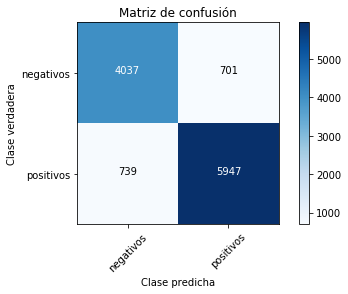

In [137]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_baseline = run_one_experiment(binary_vect_baseline, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_baseline)

In [138]:
len(all_experiments_results)

3

## Experimento 1: Remocion de stop words

In [139]:
spanish_stopwords = stopwords.words('spanish')

In [140]:
tf_vect_stopwords = CountVectorizer(stop_words = spanish_stopwords,
                                    analyzer = 'word',
                                    tokenizer = default_tokenize,
                                    lowercase = True)
tf_idf_vect_stopwords = TfidfVectorizer(stop_words = spanish_stopwords,
                                        analyzer = 'word',
                                        tokenizer = default_tokenize,
                                        lowercase = True)
binary_vect_stopwords = CountVectorizer(stop_words = spanish_stopwords,
                                        analyzer = 'word',
                                        tokenizer = default_tokenize,
                                        lowercase = True,
                                        binary=True)

### TF stop words

Numero de caracteristicas:  (26653, 48099)

train time: 2.390s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8714591228004352
alpha: 3

Exactitud: 0.8688725490196079
F1_score: 0.8646057748870303
Precision: 0.865588138200664
Recall: 0.8637157814309797

             precision    recall  f1-score   support

   negative     0.8478    0.8335    0.8406      4738
   positive     0.8834    0.8940    0.8886      6686

avg / total     0.8686    0.8689    0.8687     11424

[[3949  789]
 [ 709 5977]]

Confusion matrix, without normalization
[[3949  789]
 [ 709 5977]]


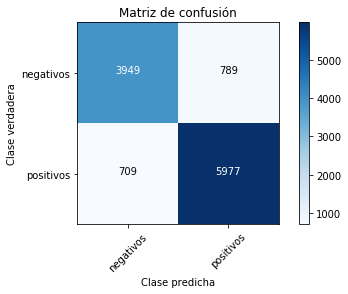

In [141]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_stopwords = run_one_experiment(tf_vect_stopwords, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_stopwords)

### TF-IDF stop words

Numero de caracteristicas:  (26653, 48118)

train time: 2.311s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8677822383971786
alpha: 1

Exactitud: 0.8618697478991597
F1_score: 0.8553913053774005
Precision: 0.8646220650029572
Recall: 0.8501715750850958

             precision    recall  f1-score   support

   negative     0.8753    0.7798    0.8248      4763
   positive     0.8539    0.9206    0.8860      6661

avg / total     0.8628    0.8619    0.8605     11424

[[3714 1049]
 [ 529 6132]]

Confusion matrix, without normalization
[[3714 1049]
 [ 529 6132]]


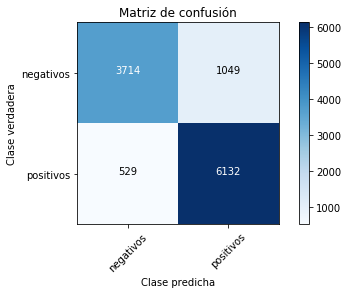

In [142]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_stopwords = run_one_experiment(tf_idf_vect_stopwords, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_stopwords)

### Binary stop words

Numero de caracteristicas:  (26653, 48099)

train time: 2.438s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8702585074850862
alpha: 3

Exactitud: 0.8684348739495799
F1_score: 0.8641232837002886
Precision: 0.8651984242008636
Recall: 0.863157386003553

             precision    recall  f1-score   support

   negative     0.8478    0.8322    0.8399      4738
   positive     0.8826    0.8941    0.8883      6686

avg / total     0.8682    0.8684    0.8683     11424

[[3943  795]
 [ 708 5978]]

Confusion matrix, without normalization
[[3943  795]
 [ 708 5978]]


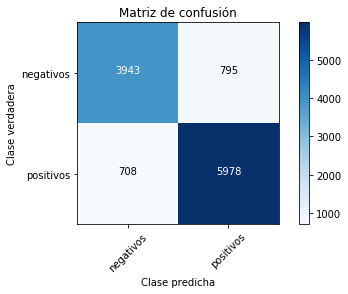

In [143]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_stopwords = run_one_experiment(binary_vect_stopwords, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_stopwords)

## Experimento 2: Stemming

In [144]:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize_stems(text):
    regexp_tokenizer = RegexpTokenizer(u'(?u)\\b\\w\\w+\\b')
    tokens =  regexp_tokenizer.tokenize(text)
    token_stems = stem_tokens(tokens, stemmer)
    return token_stems

In [145]:
#Prueba de los metodos anteriores
print(stemmer.stem("frutivoro"))
print(tokenize_stems(
    "holaaaa como estas estaaaas creerías en mi si lloviera mañana, tu crees en mi cartas ¡¡ ¿¿. a e i o u aeiou"))

frutivor
['holaaa', 'com', 'estas', 'estaa', 'cre', 'en', 'mi', 'si', 'llov', 'mañan', 'tu', 'cre', 'en', 'mi', 'cart', 'aeiou']


In [146]:
tf_vect_stemming = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_stems,
                lowercase = True)

tf_idf_vect_stemming = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_stems,
                lowercase = True)

binary_vect_stemming = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_stems,
                lowercase = True,
                binary=True)

### TF stemming

Numero de caracteristicas:  (26653, 32900)

train time: 2.242s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8789254492927625
alpha: 3

Exactitud: 0.8722864145658263
F1_score: 0.8694185474606552
Precision: 0.8673753112855899
Recall: 0.8723819433562466

             precision    recall  f1-score   support

   negative     0.8284    0.8729    0.8501      4738
   positive     0.9064    0.8718    0.8888      6686

avg / total     0.8740    0.8723    0.8727     11424

[[4136  602]
 [ 857 5829]]

Confusion matrix, without normalization
[[4136  602]
 [ 857 5829]]


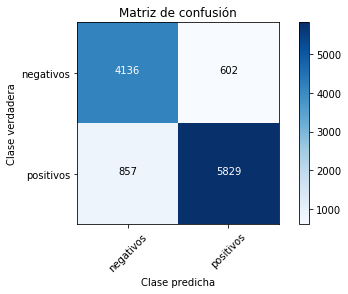

In [147]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_stemming = run_one_experiment(tf_vect_stemming, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_stemming)

### TF-IDF stemming

Numero de caracteristicas:  (26653, 32850)

train time: 2.085s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8727347765729937
alpha: 1

Exactitud: 0.8683473389355743
F1_score: 0.8632768355827352
Precision: 0.8677956816803122
Recall: 0.8600934560910471

             precision    recall  f1-score   support

   negative     0.8653    0.8104    0.8369      4763
   positive     0.8703    0.9098    0.8896      6661

avg / total     0.8682    0.8683    0.8677     11424

[[3860  903]
 [ 601 6060]]

Confusion matrix, without normalization
[[3860  903]
 [ 601 6060]]


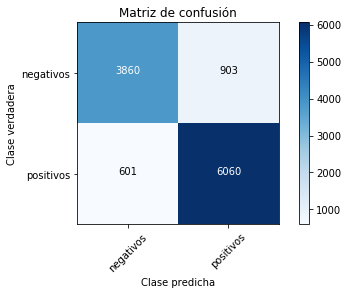

In [148]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_stemming = run_one_experiment(tf_idf_vect_stemming, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_stemming)

### Binary stemming

Numero de caracteristicas:  (26653, 32900)

train time: 2.246s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8780249878062507
alpha: 3

Exactitud: 0.8728991596638656
F1_score: 0.8698306208382465
Precision: 0.8681210488521902
Recall: 0.8720752662361465

             precision    recall  f1-score   support

   negative     0.8331    0.8672    0.8498      4738
   positive     0.9031    0.8769    0.8898      6686

avg / total     0.8741    0.8729    0.8732     11424

[[4109  629]
 [ 823 5863]]

Confusion matrix, without normalization
[[4109  629]
 [ 823 5863]]


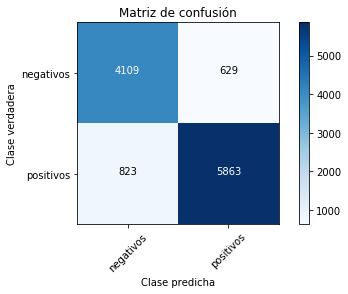

In [149]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_stemming = run_one_experiment(binary_vect_stemming, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_stemming)

## Experimento 3: Lematizacion

In [150]:
lemmaDict = {}
with open('lemma_data/lemmatization-es.txt', 'rb') as f:
   data = f.read().decode('utf8').replace(u'\r', u'').split(u'\n')
   data = [a.split(u'\t') for a in data]
   
for a in data:
   if len(a) >1:
      lemmaDict[a[1]] = a[0]
   
def lemmatize(word):
   return lemmaDict.get(word, word)
   
def test():
   for a in [ u'salió', u'usuarios', u'abofeteéis', u'diferenciando', u'diferenciándola' ]:
      print(lemmatize(a))
   
test()

salir
usuario
abofetear
diferenciar
diferenciándola


In [151]:
# Prueba del metodo de lematizacion
lemmatize("computadores")

'computador'

In [152]:
def lemmatizer(tokens):
    lemmatized = []
    for item in tokens:
        lemma = lemmatize(item)
        lemmatized.append(lemma)
    return lemmatized

def tokenize_lemmas(text):
    regexp_tokenizer = RegexpTokenizer(u'(?u)\\b\\w\\w+\\b')
    tokens =  regexp_tokenizer.tokenize(text)
    token_lemmas = lemmatizer(tokens)
    return token_lemmas

In [153]:
# Prueba del tokenizer
print(tokenize_lemmas(
    "holaaaa como estas estaaaas creerías en mi si lloviera mañana, tu crees en mi cartas ¡¡ ¿¿. a e i o u aeiou"))

['holaaaa', 'comer', 'este', 'estaaaas', 'creer', 'en', 'mi', 'si', 'llover', 'mañana', 'tu', 'creer', 'en', 'mi', 'carta', 'aeiou']


In [154]:
tf_vect_lemmatize = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_lemmas,
                lowercase = True)

tf_idf_vect_lemmatize = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_lemmas,
                lowercase = True)

binary_vect_lemmatize = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_lemmas,
                lowercase = True,
                binary=True)

### TF lemmatize

Numero de caracteristicas:  (26653, 36795)

train time: 2.381s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8784752185495066
alpha: 3

Exactitud: 0.8731617647058824
F1_score: 0.8702093485142632
Precision: 0.8683149128032817
Recall: 0.8728223083408475

             precision    recall  f1-score   support

   negative     0.8314    0.8708    0.8506      4738
   positive     0.9053    0.8748    0.8898      6686

avg / total     0.8746    0.8732    0.8735     11424

[[4126  612]
 [ 837 5849]]

Confusion matrix, without normalization
[[4126  612]
 [ 837 5849]]


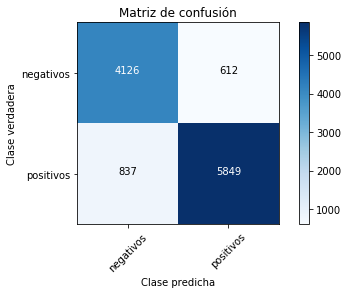

In [155]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_lemmatize = run_one_experiment(tf_vect_lemmatize, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_lemmatize)

### TF-IDF lemmatize

Numero de caracteristicas:  (26653, 36771)

train time: 2.422s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.872584699658575
alpha: 1

Exactitud: 0.8671218487394958
F1_score: 0.8617593858217507
Precision: 0.8672532983810259
Recall: 0.8580853771895487

             precision    recall  f1-score   support

   negative     0.8678    0.8037    0.8345      4763
   positive     0.8667    0.9125    0.8890      6661

avg / total     0.8672    0.8671    0.8663     11424

[[3828  935]
 [ 583 6078]]

Confusion matrix, without normalization
[[3828  935]
 [ 583 6078]]


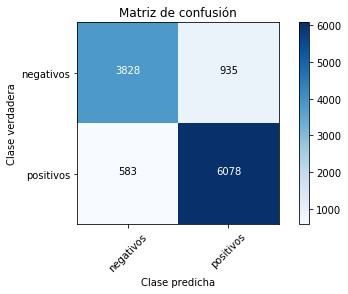

In [156]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_lemmatize = run_one_experiment(tf_idf_vect_lemmatize, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_lemmatize)

### Binary lemmatize

Numero de caracteristicas:  (26653, 36795)

train time: 2.363s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8786628146925299
alpha: 3

Exactitud: 0.8737745098039216
F1_score: 0.8705021746731701
Precision: 0.8692296943603575
Recall: 0.8720236851332908

             precision    recall  f1-score   support

   negative     0.8384    0.8618    0.8499      4738
   positive     0.9001    0.8823    0.8911      6686

avg / total     0.8745    0.8738    0.8740     11424

[[4083  655]
 [ 787 5899]]

Confusion matrix, without normalization
[[4083  655]
 [ 787 5899]]


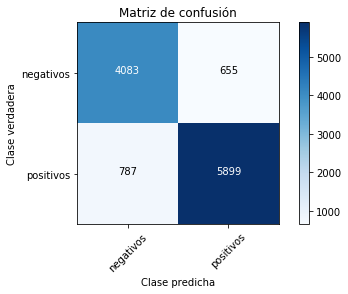

In [157]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_lemmatize = run_one_experiment(binary_vect_lemmatize, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_lemmatize)

## Experimento 4: Remocion de URLs

In [158]:
def tokenize_no_urls(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text_no_urls = re.sub(url_regex, '', text, flags=re.MULTILINE)
    regexp_tokenizer = RegexpTokenizer(u'(?u)\\b\\w\\w+\\b')
    tokens =  regexp_tokenizer.tokenize(text_no_urls)
    return tokens

In [159]:
# Prueba de la tokenizacion sin urls
print(tokenize_no_urls(
    "holaaaa cómo http://estas creerías https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python mi si lloviera \t  mañana, tu crees en mi cartas ¡¡ ¿¿. aeiou"))

['holaaaa', 'cómo', 'creerías', 'mi', 'si', 'lloviera', 'mañana', 'tu', 'crees', 'en', 'mi', 'cartas', 'aeiou']


In [160]:
tf_vect_no_urls = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_no_urls,
                lowercase = True)

tf_idf_vect_no_urls = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_no_urls,
                lowercase = True)

binary_vect_no_urls = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_no_urls,
                lowercase = True,
                binary=True)

### TF sin URLs

Numero de caracteristicas:  (26653, 40405)

train time: 2.542s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8784001800922973
alpha: 3

Exactitud: 0.873686974789916
F1_score: 0.8707815963557358
Precision: 0.868830032820542
Recall: 0.8735169801581324

             precision    recall  f1-score   support

   negative     0.8313    0.8725    0.8514      4738
   positive     0.9064    0.8745    0.8902      6686

avg / total     0.8752    0.8737    0.8741     11424

[[4134  604]
 [ 839 5847]]

Confusion matrix, without normalization
[[4134  604]
 [ 839 5847]]


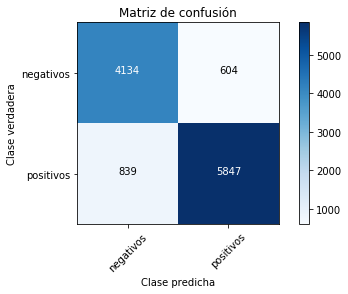

In [161]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_no_urls = run_one_experiment(tf_vect_no_urls, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_no_urls)

### TF-IDF sin URLs

Numero de caracteristicas:  (26653, 40441)

train time: 2.333s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8729974111732263
alpha: 1

Exactitud: 0.8652836134453782
F1_score: 0.8593681058747584
Precision: 0.8668603220966644
Recall: 0.8548040503754246

             precision    recall  f1-score   support

   negative     0.8733    0.7917    0.8305      4763
   positive     0.8604    0.9179    0.8882      6661

avg / total     0.8658    0.8653    0.8642     11424

[[3771  992]
 [ 547 6114]]

Confusion matrix, without normalization
[[3771  992]
 [ 547 6114]]


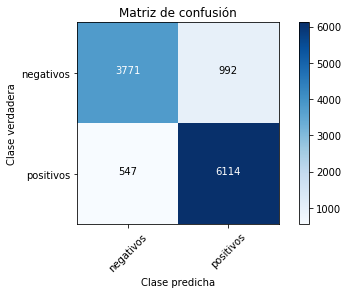

In [162]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_no_urls = run_one_experiment(tf_idf_vect_no_urls, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_no_urls)

### Binary sin URLs

Numero de caracteristicas:  (26653, 40405)

train time: 2.445s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8779124301204367
alpha: 3

Exactitud: 0.8757002801120448
F1_score: 0.8725502458474934
Precision: 0.8711164442341242
Recall: 0.874314593209452

             precision    recall  f1-score   support

   negative     0.8393    0.8662    0.8525      4738
   positive     0.9030    0.8824    0.8926      6686

avg / total     0.8765    0.8757    0.8760     11424

[[4104  634]
 [ 786 5900]]

Confusion matrix, without normalization
[[4104  634]
 [ 786 5900]]


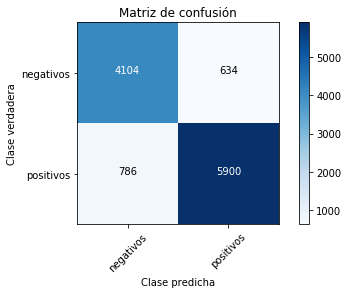

In [163]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_no_urls = run_one_experiment(binary_vect_no_urls, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_no_urls)

## Experimento 5: Remocion de letras repetidas

El siguiente metodo es tomado y adaptado del libro de Jacob Perkins "Python 3 Text-Processing with NLTK 3 Cookbook". El codigo se puede encontrar en su repositorio de github. https://github.com/japerk/nltk3-cookbook/blob/master/replacers.py. Se adapto para que funcionara con el lenguaje español.

In [164]:
class RepeatReplacer(object):
    """ Removes repeating characters until a valid word is found.
    >>> replacer = RepeatReplacer()
    >>> replacer.replace('looooove')
    'love'
    >>> replacer.replace('oooooh')
    'ooh'
    >>> replacer.replace('goose')
    'goose'
    """
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'

    def replace(self, word):
        
        # El metodo se modifica en este fragmento para que funcione con el idioma español
        lemma = lemmatize(word)
        
        if wn.synsets(lemma, lang='spa'):
            return word

        repl_word = self.repeat_regexp.sub(self.repl, word)

        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word

In [165]:
# Pruebas del metodo de reemplazamiento
replacer = RepeatReplacer()
print(wn.synsets("poseer", lang='spa'))
replacer.replace('creeeeeer')

[Synset('have.v.01'), Synset('own.v.01'), Synset('possess.v.03'), Synset('hold.v.11')]


'creer'

In [166]:
replacer = RepeatReplacer()
def norm_repeated_letters(tokens, replacer):  
    norm_tokens = []
    for item in tokens:
        norm_tokens.append(replacer.replace(item))
    return norm_tokens

def tokenize_norm_letters(text):
    regexp_tokenizer = RegexpTokenizer(u'(?u)\\b\\w\\w+\\b')
    tokens =  regexp_tokenizer.tokenize(text)
    norm_letters = norm_repeated_letters(tokens, replacer)
    return norm_letters

In [167]:
print(tokenize_norm_letters(
    "holaaaa cómo http://estas estaaaas creerías mi si lloviera mañana, tu crees en mi cartas ¡¡ ¿¿. a e i o u aeiou"))

['hola', 'cómo', 'htp', 'estas', 'estas', 'creerías', 'mi', 'si', 'lloviera', 'mañana', 'tu', 'crees', 'en', 'mi', 'cartas', 'aeiou']


In [168]:
tf_vect_norm_letters = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_norm_letters,
                lowercase = True)

tf_idf_vect_norm_letters = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_norm_letters,
                lowercase = True)

binary_vect_norm_letters = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize_norm_letters,
                lowercase = True,
                binary=True)

### TF sin letras repetidas

Numero de caracteristicas:  (26653, 47550)

train time: 2.394s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8784001800922973
alpha: 3

Exactitud: 0.8744747899159664
F1_score: 0.8712718657275876
Precision: 0.8698881951175529
Recall: 0.872960163099826

             precision    recall  f1-score   support

   negative     0.8382    0.8641    0.8510      4738
   positive     0.9015    0.8818    0.8916      6686

avg / total     0.8753    0.8745    0.8747     11424

[[4094  644]
 [ 790 5896]]

Confusion matrix, without normalization
[[4094  644]
 [ 790 5896]]


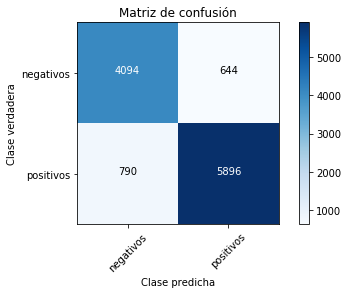

In [169]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_norm_letters = run_one_experiment(tf_vect_norm_letters, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_norm_letters)

### TF-IDF sin letras repetidas

Numero de caracteristicas:  (26653, 47582)

train time: 2.472s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8720219112295051
alpha: 1

Exactitud: 0.8647584033613446
F1_score: 0.8584209327448173
Precision: 0.8676954389483826
Recall: 0.8531571854972381

             precision    recall  f1-score   support

   negative     0.8791    0.7833    0.8285      4763
   positive     0.8563    0.9230    0.8884      6661

avg / total     0.8658    0.8648    0.8634     11424

[[3731 1032]
 [ 513 6148]]

Confusion matrix, without normalization
[[3731 1032]
 [ 513 6148]]


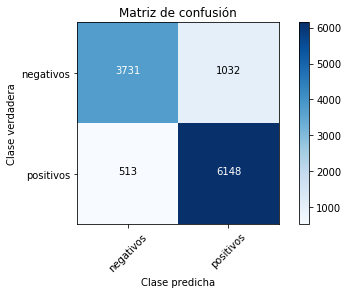

In [170]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_norm_letters = run_one_experiment(tf_idf_vect_norm_letters, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_norm_letters)

### Binary sin letras repetidas

Numero de caracteristicas:  (26653, 47550)

train time: 2.231s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8783626608636926
alpha: 3

Exactitud: 0.874562324929972
F1_score: 0.8709512304339441
Precision: 0.8705475531099822
Recall: 0.8713746281835864

             precision    recall  f1-score   support

   negative     0.8461    0.8527    0.8494      4738
   positive     0.8950    0.8901    0.8925      6686

avg / total     0.8747    0.8746    0.8746     11424

[[4040  698]
 [ 735 5951]]

Confusion matrix, without normalization
[[4040  698]
 [ 735 5951]]


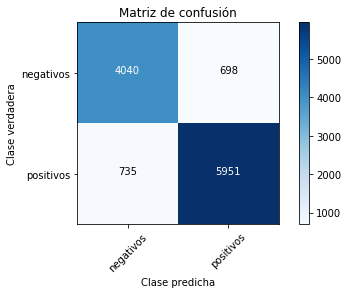

In [171]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_norm_letters = run_one_experiment(binary_vect_norm_letters, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_norm_letters)

## Experimento 6: Remocion de terminos poco comunes (pruning < 10)

In [172]:
tf_vect_pruning10 = CountVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True,
                min_df=10)

tf_idf_vect_pruning10 = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True,
                min_df=10)

binary_vect_pruning10 = CountVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True,
                binary=True,
                min_df=10)

### TF pruning < 10

Numero de caracteristicas:  (26653, 4348)

train time: 2.333s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8697332382846209
alpha: 3

Exactitud: 0.8637079831932774
F1_score: 0.861046667981426
Precision: 0.8586984141696629
Recall: 0.8652684231347496

             precision    recall  f1-score   support

   negative     0.8116    0.8744    0.8418      4738
   positive     0.9058    0.8561    0.8803      6686

avg / total     0.8667    0.8637    0.8643     11424

[[4143  595]
 [ 962 5724]]

Confusion matrix, without normalization
[[4143  595]
 [ 962 5724]]


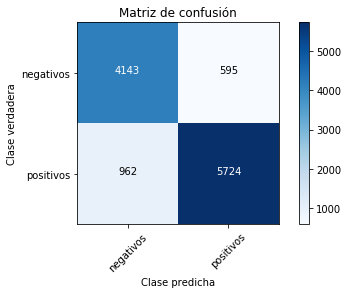

In [173]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_pruning10 = run_one_experiment(tf_vect_pruning10, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_pruning10)

### TF-IDF pruning < 10

Numero de caracteristicas:  (26653, 4348)

train time: 2.057s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8707462574569467
alpha: 1

Exactitud: 0.868172268907563
F1_score: 0.8641741264850373
Precision: 0.8649005248344532
Recall: 0.8635028625896152

             precision    recall  f1-score   support

   negative     0.8464    0.8354    0.8409      4763
   positive     0.8834    0.8916    0.8875      6661

avg / total     0.8680    0.8682    0.8680     11424

[[3979  784]
 [ 722 5939]]

Confusion matrix, without normalization
[[3979  784]
 [ 722 5939]]


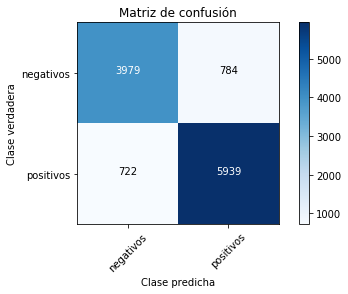

In [174]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_pruning10 = run_one_experiment(tf_idf_vect_pruning10, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_pruning10)

### Binary pruning < 10

Numero de caracteristicas:  (26653, 4348)

train time: 2.485s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8673695268825273
alpha: 3

Exactitud: 0.8632703081232493
F1_score: 0.8604502058334063
Precision: 0.8582067741955117
Recall: 0.8641565883589343

             precision    recall  f1-score   support

   negative     0.8137    0.8694    0.8406      4738
   positive     0.9027    0.8590    0.8803      6686

avg / total     0.8658    0.8633    0.8638     11424

[[4119  619]
 [ 943 5743]]

Confusion matrix, without normalization
[[4119  619]
 [ 943 5743]]


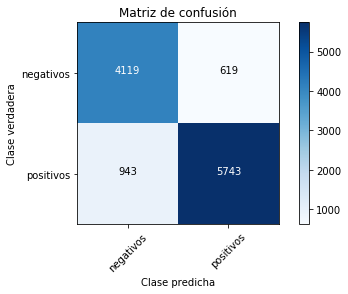

In [175]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_pruning10 = run_one_experiment(binary_vect_pruning10, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_pruning10)

## Experimento 7: Remocion de terminos poco comunes (pruning < 5)

In [176]:
tf_vect_pruning5 = CountVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True,
                min_df=5)

tf_idf_vect_pruning5 = TfidfVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True,
                min_df=5)

binary_vect_pruning5 = CountVectorizer(
                analyzer = 'word',
                tokenizer = default_tokenize,
                lowercase = True,
                binary=True,
                min_df=5)

### TF pruning < 5

Numero de caracteristicas:  (26653, 7822)

train time: 2.441s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8729974111732263
alpha: 3

Exactitud: 0.8686099439775911
F1_score: 0.8660044777481544
Precision: 0.8636410467096867
Recall: 0.8701327042248648

             precision    recall  f1-score   support

   negative     0.8178    0.8791    0.8473      4738
   positive     0.9095    0.8612    0.8847      6686

avg / total     0.8715    0.8686    0.8692     11424

[[4165  573]
 [ 928 5758]]

Confusion matrix, without normalization
[[4165  573]
 [ 928 5758]]


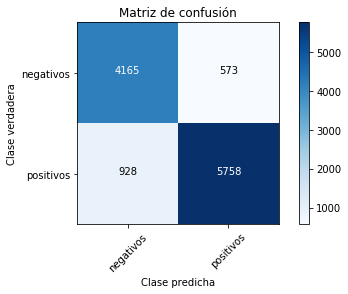

In [177]:
optimal_parameters = {'alpha': [3]}
clf_tf_vect_pruning5 = run_one_experiment(tf_vect_pruning5, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_tf_vect_pruning5)

### TF-IDF pruning < 5

Numero de caracteristicas:  (26653, 7854)

train time: 2.286s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8735601996022961
alpha: 1

Exactitud: 0.8693977591036415
F1_score: 0.8652512384996462
Precision: 0.8665593765091546
Recall: 0.8641050750790913

             precision    recall  f1-score   support

   negative     0.8512    0.8322    0.8416      4763
   positive     0.8819    0.8960    0.8889      6661

avg / total     0.8691    0.8694    0.8692     11424

[[3964  799]
 [ 693 5968]]

Confusion matrix, without normalization
[[3964  799]
 [ 693 5968]]


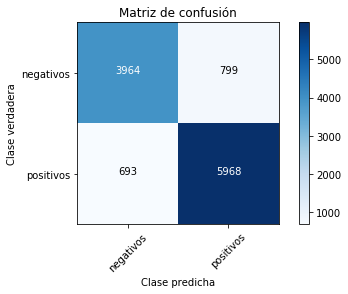

In [178]:
optimal_parameters = {'alpha': [1]}
clf_tf_idf_vect_pruning5 = run_one_experiment(tf_idf_vect_pruning5, optimal_parameters, MultinomialNB(), 30)
all_experiments_results.append(clf_tf_idf_vect_pruning5)

### Binary pruning < 5

Numero de caracteristicas:  (26653, 7822)

train time: 2.125s

Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8723971035155518
alpha: 3

Exactitud: 0.8688725490196079
F1_score: 0.8661064379659025
Precision: 0.8638783718947245
Recall: 0.8696498811109243

             precision    recall  f1-score   support

   negative     0.8212    0.8742    0.8469      4738
   positive     0.9066    0.8651    0.8854      6686

avg / total     0.8712    0.8689    0.8694     11424

[[4142  596]
 [ 902 5784]]

Confusion matrix, without normalization
[[4142  596]
 [ 902 5784]]


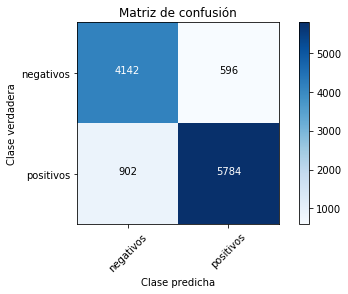

In [179]:
optimal_parameters = {'alpha': [3]}
clf_binary_vect_pruning5 = run_one_experiment(binary_vect_pruning5, optimal_parameters, MultinomialNB(), 40)
all_experiments_results.append(clf_binary_vect_pruning5)

In [180]:
len(all_experiments_results)

24

In [181]:
import xlsxwriter

In [182]:
# Create a workbook and add a worksheet.
# workbook = xlsxwriter.Workbook('result_es_twitter_sa_nb.xlsx')
# worksheet = workbook.add_worksheet()
# row = 0
# col = 0
# for exp in all_experiments_results:
#     worksheet.write(row, col, exp[0])
#     row += 1
#     worksheet.write(row, col, exp[1])
#     row += 1
#     worksheet.write(row, col, exp[2])
#     row += 1
#     worksheet.write(row, col, exp[3])
#     row += 1
#     worksheet.write(row, col, exp[4])
#     row += 1
#     worksheet.write(row, col, exp[5])
#     row += 1
#     worksheet.write(row, col, exp[6])
#     row += 1
#     worksheet.write(row, col, exp[7])
#     row += 1
#     worksheet.write(row, col, exp[8])
#     row += 1
#     row += 1
#     if row == 30:
#         row = 0
#         col += 1
# workbook.close()

# Etapa de seleccion de caracteristicas
La siguiente etapa se realiza con los mejores resultados para cada una de las representaciones (tf, tf-idf y binaria) con el fin de evaluar que tan efectivo es, además de la limpieza (primera etapa del pre-procesamiento), el filtrado de caracteristicas segun la importancia relativa a cada clase (segunda etapa del pre-procesamiento). Para esto se usan dos metodos comunmente usados en la literatura, mutual information y chi2.

In [183]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

In [184]:
def run_filtered_experiments(vectorizer, grid_parameters, clf_type, state, filter_function):
    results = []
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for percent in percents:
        print("percent: ", percent)
        X_train, X_test, y_train, y_test = train_test_split(total_data_content, 
                                                            total_data_target, 
                                                            test_size=0.3, 
                                                            random_state=state)
        X_train_vector, X_test_vector = fit_train_test_vectors(vectorizer, X_train, X_test)
        
        filter_percent = SelectPercentile(filter_function, percentile=percent)
        X_train_filtered = filter_percent.fit_transform(X_train_vector,y_train)
        X_test_filtered = filter_percent.transform(X_test_vector)
        
        clf = train_nl_classifier(grid_parameters, clf_type, X_train_filtered, y_train)
        y_pred = clf.predict(X_test_filtered)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1_score = metrics.f1_score(y_test, y_pred, average="macro")
        results.append((accuracy, f1_score, clf.best_score_, X_test_filtered, y_test, clf, percent, X_train_filtered))
    return results

In [185]:
def print_filtered_results(filtered_results, grid_parameters):
    selected_clf_info = max(filtered_results)
    print("Numero de caracteristicas: ", selected_clf_info[7].shape)
    print()
    print("Best Accuracy: ", selected_clf_info[0])
    print("Best F1-score: ", selected_clf_info[1])
    print("Best score selected: ", selected_clf_info[2])
    print("Best percent: ", selected_clf_info[6])
    selected_clf = selected_clf_info[5]
    print_clf_best_params(grid_parameters, selected_clf)
    print()
    X_t = selected_clf_info[3]
    y_t = selected_clf_info[4]
    test_nl_classifier(selected_clf, X_t, y_t)
    
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    accuracy_list = []
    f1_score_list = []
    
    for result in filtered_results:
        print("Percent: ", result[6])
        print("Accuracy: ", result[0])
        print("F1-score: ", result[1])
        print("Best score: ", result[2])
        print("Numero de caracteristicas: ", result[7].shape)
        result_clf = result[5]
        print_clf_best_params(grid_parameters, result_clf)
        print()

## Experimentos con Chi2

In [186]:
optimal_parameters = {'alpha': [2]}
chi2_results = run_filtered_experiments(tf_vect_baseline, optimal_parameters, MultinomialNB(), 10, chi2)

percent:  10
train time: 2.138s

percent:  20
train time: 2.192s

percent:  30
train time: 2.381s

percent:  40
train time: 2.148s

percent:  50
train time: 2.200s

percent:  60
train time: 2.183s

percent:  70
train time: 2.503s

percent:  80
train time: 2.530s

percent:  90
train time: 2.545s

percent:  100
train time: 2.520s



Numero de caracteristicas:  (26653, 19326)

Best Accuracy:  0.8799019607843137
Best F1-score:  0.8770697834417325
Best score selected:  0.8930701984767193
Best percent:  40
Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8930701984767193
alpha: 2


Exactitud: 0.8799019607843137
F1_score: 0.8770697834417325
Precision: 0.8755475090394456
Recall: 0.8789962078386969

             precision    recall  f1-score   support

   negative     0.8438    0.8736    0.8584      4761
   positive     0.9073    0.8844    0.8957      6663

avg / total     0.8808    0.8799    0.8802     11424

[[4159  602]
 [ 770 5893]]

Confusion matrix, without normalization
[[4159  602]
 [ 770 5893]]
Percent:  10
Accuracy:  0.8721988795518207
F1-score:  0.8698894461567639
Best score:  0.8846658912692755
Numero de caracteristicas:  (26653, 4831)
Mejor resultado y parametro encontrados:
Mejor resultado (accuracy cv):  0.8846658912692755
alpha: 2


Percent:  20
Accuracy:  0.8761379551820728
F1-s

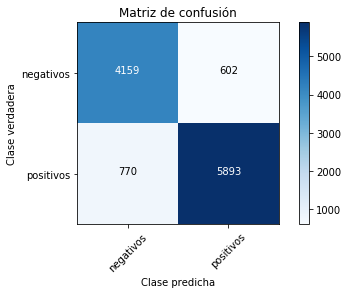

In [187]:
print_filtered_results(chi2_results, optimal_parameters)

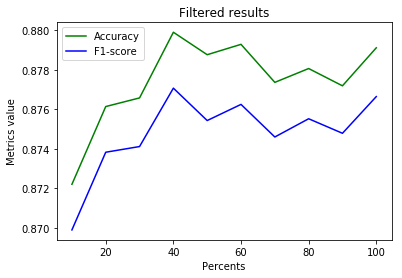

In [188]:
percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracy_list = []
f1_score_list = []
for result in chi2_results:
    accuracy_list.append(result[0])
    f1_score_list.append(result[1])

    #make a plot
ax = plt.gca()
# ax.set_xscale('linear')
# ax.set_yscale('log')
ax.plot(percents, accuracy_list,'g', label = 'Accuracy')
ax.plot(percents, f1_score_list,'b', label = 'F1-score')
#Set limits and titles
plt.ylim([0,1])
plt.xlabel('Percents')
plt.ylabel('Metrics value')
plt.legend()
plt.title('Filtered results')
# plt.axis('scaled')
plt.autoscale(enable=True, axis='y')
 
# plt.savefig('Tuning.png')
plt.show()